# Métricas de Avaliação - Dataset SVM KubeMon

Este notebook prepara os dados a serem utilizados para os modelos.


In [7]:
# Importações necessárias
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📚 Bibliotecas importadas com sucesso!")
print("🎯 Pronto para avaliar métricas do modelo SVM")

📚 Bibliotecas importadas com sucesso!
🎯 Pronto para avaliar métricas do modelo SVM


In [ ]:
#Variáveis globais
import pickle
import lib_analise 
info_modelo = lib_analise.get_info_modelo()  # para garantir que a função está carregada da

nome_dataset = info_modelo['nome_dataset']
arq_dataset_csv = info_modelo['parametros']['arq_dataset_csv']
arq_dataset_pkl = info_modelo['parametros']['arq_dataset_pkl']

#carregar os datasets de teste, treino e validação do arquivo pickle
with open(arq_dataset_pkl, 'rb') as f:
    datasets = pickle.load(f)


## 1. Carregamento e Preparação dos Dados

In [9]:
# 1) Carregamento e higienização (por dataset)

# Carregar o dataset
print("📂 Carregando dataset svm.csv...")

try:
    df = pd.read_csv(arq_dataset_csv)
    print(f"✅ Dataset carregado com sucesso!")
    print(f"📊 Dimensões: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
    
except Exception as e:
    print(f"❌ Erro ao carregar dataset: {e}")
    print("🔄 Tentando carregar uma amostra...")
    try:
        df = pd.read_csv(arq_dataset_csv, nrows=10000)
        print(f"✅ Amostra carregada: {df.shape[0]:,} linhas")
    except:
        raise Exception("Não foi possível carregar o dataset")

# Verificar se a coluna target existe
if 'target' not in df.columns:
    print("❌ Coluna 'target' não encontrada!")
    print(f"Colunas disponíveis: {list(df.columns)}")
    raise Exception("Coluna target não encontrada")

print(f"\n📋 Informações do Target:")
target_counts = df['target'].value_counts()
print(f"   • Classes: {dict(target_counts)}")
for classe, count in target_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   • {classe}: {count:,} ({percentage:.1f}%)")

# Mostrar informações gerais
print(f"\n📊 Informações Gerais:")
print(f"   • Valores ausentes no target: {df['target'].isnull().sum()}")
print(f"   • Total de features: {df.shape[1] - 1}")
print(f"   • Balanceamento: {'Balanceado' if target_counts.min() / target_counts.max() > 0.8 else 'Desbalanceado'}")

📂 Carregando dataset svm.csv...
✅ Dataset carregado com sucesso!
📊 Dimensões: 80,648 linhas × 126 colunas

📋 Informações do Target:
   • Classes: {'interf': np.int64(45660), 'normal': np.int64(34988)}
   • interf: 45,660 (56.6%)
   • normal: 34,988 (43.4%)

📊 Informações Gerais:
   • Valores ausentes no target: 0
   • Total de features: 125
   • Balanceamento: Desbalanceado


In [10]:
# Preparação dos dados
print("🔧 Preparando dados para treinamento...")

# Separar features e target
colunas_excluir = ['os_timestamp', 'node_name', 'iteration', 'target']
colunas_excluir = [col for col in colunas_excluir if col in df.columns]

# Selecionar apenas features numéricas
features_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
features_para_modelo = [col for col in features_numericas if col not in colunas_excluir]

print(f"📊 Features para o modelo:")
print(f"   • Total de features: {len(features_para_modelo)}")
print(f"   • Colunas excluídas: {colunas_excluir}")

# Preparar X e y
X = df[features_para_modelo].copy()
y = df['target'].copy()

# Tratar valores ausentes
valores_ausentes = X.isnull().sum().sum()
if valores_ausentes > 0:
    print(f"   • Preenchendo {valores_ausentes:,} valores ausentes com a mediana...")
    X = X.fillna(X.median())

# Codificar target se necessário
le = LabelEncoder()
if y.dtype == 'object':
    y_encoded = le.fit_transform(y)
    classes_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"   • Target codificado: {classes_mapping}")
else:
    y_encoded = y.values
    classes_mapping = None

print(f"\n✅ Dados preparados:")
print(f"   • Shape X: {X.shape}")
print(f"   • Shape y: {len(y_encoded)}")
print(f"   • Classes únicas: {np.unique(y_encoded)}")

🔧 Preparando dados para treinamento...
📊 Features para o modelo:
   • Total de features: 122
   • Colunas excluídas: ['os_timestamp', 'node_name', 'iteration', 'target']
   • Target codificado: {'interf': np.int64(0), 'normal': np.int64(1)}

✅ Dados preparados:
   • Shape X: (80648, 122)
   • Shape y: 80648
   • Classes únicas: [0 1]


## 2. Divisão dos Dados e Normalização
# Utilizando Yeo-Johnson

In [11]:
# 3) Particionamento estratificado 40/30/30

# Divisão treino/teste
print("📊 Dividindo dados em treino e teste...")

# Dividindo o teste mantendo a proporção das classes (stratify) em 40% treino e 60% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.6, 
    random_state=42, 
    stratify=y_encoded
)

# Dividindo o teste em teste e validação (50%/50%)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_test
)

print(f"📊 Divisão dos dados:")
print(f"   • Treino: {X_train.shape[0]:,} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   • Teste:  {X_test.shape[0]:,} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   • Validação: {X_val.shape[0]:,} amostras ({X_val.shape[0]/len(X)*100:.1f}%)")

# Verificar distribuição das classes
print(f"\n📋 Distribuição das classes:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

for classe in unique_train:
    train_pct = (counts_train[unique_train == classe][0] / len(y_train)) * 100
    test_pct = (counts_test[unique_test == classe][0] / len(y_test)) * 100
    val_pct = (counts_val[unique_val == classe][0] / len(y_val)) * 100
    print(f"   • Classe {classe}: Treino {train_pct:.1f}% | Teste {test_pct:.1f}% | Validação {val_pct:.1f}%")

# Normalização dos dados usando Yeo-Johnson
print(f"\n⚖️ Aplicando transformação Yeo-Johnson...")
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
# O fit é feito apenas no conjunto de treino para evitar data leakage
X_train_scaled = yeo_johnson_transformer.fit_transform(X_train)
X_test_scaled = yeo_johnson_transformer.transform(X_test)
X_val_scaled = yeo_johnson_transformer.transform(X_val)

print(f"   ✅ Transformação Yeo-Johnson aplicada com StandardScaler integrado")
print(f"   • Média treino antes: {X_train.mean().mean():.3f} | depois: {X_train_scaled.mean():.3f}")
print(f"   • Std treino antes: {X_train.std().mean():.3f} | depois: {X_train_scaled.std().mean():.3f}")
print(f"   • Média teste antes: {X_test.mean().mean():.3f} | depois: {X_test_scaled.mean():.3f}")
print(f"   • Std teste antes: {X_test.std().mean():.3f} | depois: {X_test_scaled.std().mean():.3f}")
print(f"   • Média validação antes: {X_val.mean().mean():.3f} | depois: {X_val_scaled.mean():.3f}")
print(f"   • Std validação antes: {X_val.std().mean():.3f} | depois: {X_val_scaled.std().mean():.3f}")

print(f"   • Transformação aplicada: Yeo-Johnson + Padronização")


📊 Dividindo dados em treino e teste...
📊 Divisão dos dados:
   • Treino: 32,259 amostras (40.0%)
   • Teste:  24,194 amostras (30.0%)
   • Validação: 24,195 amostras (30.0%)

📋 Distribuição das classes:
   • Classe 0: Treino 56.6% | Teste 56.6% | Validação 56.6%
   • Classe 1: Treino 43.4% | Teste 43.4% | Validação 43.4%

⚖️ Aplicando transformação Yeo-Johnson...
   ✅ Transformação Yeo-Johnson aplicada com StandardScaler integrado
   • Média treino antes: 970513.048 | depois: -0.000
   • Std treino antes: 4262885.915 | depois: 0.805
   • Média teste antes: 986004.100 | depois: -0.000
   • Std teste antes: 4481052.608 | depois: 1.453
   • Média validação antes: 982812.774 | depois: -0.001
   • Std validação antes: 4428113.690 | depois: 0.793
   • Transformação aplicada: Yeo-Johnson + Padronização


In [12]:
## 3. Gera pickles com os datasets e grava um arquivo
# Salvar datasets em arquivos pickle gera um único arquivo para todos datasets
import pickle  

with open(arq_dataset_pkl, 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'X_test': X_test,
        'X_val': X_val,
        'y_train': y_train,
        'y_test': y_test,
        'y_val': y_val,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'X_val_scaled': X_val_scaled,
        'classes_mapping': classes_mapping, 
        'features_ganho_informacao': None
    }, f)

print(f"✅ Datasets salvos em arquivos pickle com sucesso!")

✅ Datasets salvos em arquivos pickle com sucesso!


In [13]:
#carregar os datasets de teste, treino e validação do arquivo pickle
with open(arq_dataset_pkl, 'rb') as f:
    datasets = pickle.load(f)

X_train = datasets['X_train']
X_test = datasets['X_test']
X_val = datasets['X_val']
y_train = datasets['y_train']
y_test = datasets['y_test']
y_val = datasets['y_val']
X_train_scaled = datasets['X_train_scaled']
X_test_scaled = datasets['X_test_scaled']
X_val_scaled = datasets['X_val_scaled']
classes_mapping = datasets['classes_mapping']



## 3. Treinamento do Modelo SVM

In [14]:
# Treinamento do modelo SVM
# Os modelos serão utilizados no dataset de validaçao
print("🤖 Treinando modelo SVM...")

# Configurar o modelo SVM
svm_model = SVC(
    kernel='rbf',           # Kernel RBF (Gaussian)
    C=1.0,                  # Parâmetro de regularização
    gamma='scale',          # Parâmetro gamma
    probability=True,       # Habilitar probabilidades para ROC-AUC
    random_state=42
)

print(f"📋 Parâmetros do SVM:")
print(f"   • Kernel: {svm_model.kernel}")
print(f"   • C: {svm_model.C}")
print(f"   • Gamma: {svm_model.gamma}")
print(f"   • Probabilidades: {svm_model.probability}")

# Treinar o modelo
print(f"\n⏳ Treinando modelo...")
svm_model.fit(X_train_scaled, y_train)

# Fazer predições
print(f"🔮 Fazendo predições...")
y_pred = svm_model.predict(X_test_scaled)
y_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]  # Probabilidades da classe positiva

print(f"\n✅ Modelo treinado com sucesso!")
print(f"   • Vetores de suporte: {svm_model.n_support_}")
print(f"   • Total de vetores de suporte: {sum(svm_model.n_support_)}")
print(f"   • Predições realizadas: {len(y_pred)}")

🤖 Treinando modelo SVM...
📋 Parâmetros do SVM:
   • Kernel: rbf
   • C: 1.0
   • Gamma: scale
   • Probabilidades: True

⏳ Treinando modelo...
🔮 Fazendo predições...

✅ Modelo treinado com sucesso!
   • Vetores de suporte: [1770 1556]
   • Total de vetores de suporte: 3326
   • Predições realizadas: 24194


## 4. Cálculo das Métricas de Avaliação

In [15]:
# Calcular todas as métricas
print("📊 Calculando métricas de avaliação...")

# Métricas básicas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC-AUC (para classificação binária)
if len(np.unique(y_test)) == 2:
    roc_auc = roc_auc_score(y_test, y_pred_proba)
else:
    # Para multi-classe, usar average='weighted'
    roc_auc = roc_auc_score(y_test, svm_model.predict_proba(X_test_scaled), multi_class='ovr', average='weighted')

print(f"\n🎯 MÉTRICAS DE AVALIAÇÃO:")
print(f"="*50)
print(f"📊 Acurácia (Accuracy):     {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 Precisão (Precision):    {precision:.4f} ({precision*100:.2f}%)")
print(f"📈 Recall (Sensibilidade):  {recall:.4f} ({recall*100:.2f}%)")
print(f"⚖️ F1-Score:               {f1:.4f} ({f1*100:.2f}%)")
print(f"📈 ROC-AUC:                {roc_auc:.4f} ({roc_auc*100:.2f}%)")
print(f"="*50)

# Interpretação das métricas
print(f"\n💡 INTERPRETAÇÃO:")
if accuracy >= 0.9:
    print(f"   • Acurácia: Excelente (≥90%)")
elif accuracy >= 0.8:
    print(f"   • Acurácia: Boa (80-90%)")
elif accuracy >= 0.7:
    print(f"   • Acurácia: Razoável (70-80%)")
else:
    print(f"   • Acurácia: Baixa (<70%)")

if f1 >= 0.9:
    print(f"   • F1-Score: Excelente (≥90%)")
elif f1 >= 0.8:
    print(f"   • F1-Score: Bom (80-90%)")
elif f1 >= 0.7:
    print(f"   • F1-Score: Razoável (70-80%)")
else:
    print(f"   • F1-Score: Baixo (<70%)")

if roc_auc >= 0.9:
    print(f"   • ROC-AUC: Excelente (≥90%)")
elif roc_auc >= 0.8:
    print(f"   • ROC-AUC: Bom (80-90%)")
elif roc_auc >= 0.7:
    print(f"   • ROC-AUC: Razoável (70-80%)")
else:
    print(f"   • ROC-AUC: Baixo (<70%)")

📊 Calculando métricas de avaliação...

🎯 MÉTRICAS DE AVALIAÇÃO:
📊 Acurácia (Accuracy):     0.9916 (99.16%)
🎯 Precisão (Precision):    0.9916 (99.16%)
📈 Recall (Sensibilidade):  0.9916 (99.16%)
⚖️ F1-Score:               0.9916 (99.16%)
📈 ROC-AUC:                0.9997 (99.97%)

💡 INTERPRETAÇÃO:
   • Acurácia: Excelente (≥90%)
   • F1-Score: Excelente (≥90%)
   • ROC-AUC: Excelente (≥90%)


## 5. Matriz de Confusão

🔲 Gerando Matriz de Confusão...

📊 MATRIZ DE CONFUSÃO:
Matriz bruta:
[[13558   140]
 [   64 10432]]


<Figure size 1000x800 with 0 Axes>

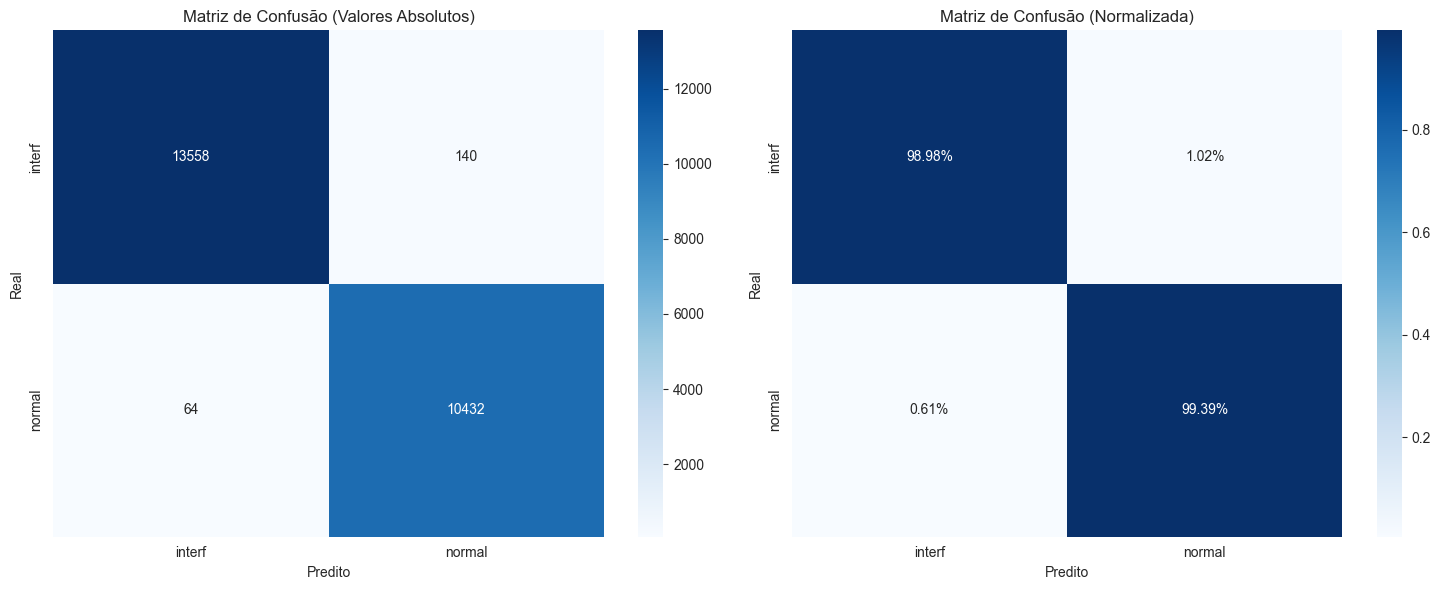


🔍 ANÁLISE DETALHADA (Classificação Binária):
   • Verdadeiros Negativos (TN): 13,558
   • Falsos Positivos (FP):      140
   • Falsos Negativos (FN):      64
   • Verdadeiros Positivos (TP): 10,432

📈 MÉTRICAS DERIVADAS:
   • Sensibilidade (Recall):     0.9939 (99.39%)
   • Especificidade:             0.9898 (98.98%)
   • Precisão (manual):          0.9868 (98.68%)


In [16]:
# Calcular matriz de confusão
print("🔲 Gerando Matriz de Confusão...")

cm = confusion_matrix(y_test, y_pred)
classes_names = le.classes_ if classes_mapping else [str(i) for i in np.unique(y_test)]

print(f"\n📊 MATRIZ DE CONFUSÃO:")
print(f"Matriz bruta:")
print(cm)

# Criar visualização da matriz de confusão
plt.figure(figsize=(10, 8))

# Matriz de confusão normalizada e não normalizada
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz não normalizada
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes_names, yticklabels=classes_names,
            ax=axes[0])
axes[0].set_title('Matriz de Confusão (Valores Absolutos)')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Real')

# Matriz normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes_names, yticklabels=classes_names,
            ax=axes[1])
axes[1].set_title('Matriz de Confusão (Normalizada)')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# Análise detalhada da matriz de confusão
if len(classes_names) == 2:  # Classificação binária
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n🔍 ANÁLISE DETALHADA (Classificação Binária):")
    print(f"   • Verdadeiros Negativos (TN): {tn:,}")
    print(f"   • Falsos Positivos (FP):      {fp:,}")
    print(f"   • Falsos Negativos (FN):      {fn:,}")
    print(f"   • Verdadeiros Positivos (TP): {tp:,}")
    
    # Métricas derivadas
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision_manual = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    print(f"\n📈 MÉTRICAS DERIVADAS:")
    print(f"   • Sensibilidade (Recall):     {sensitivity:.4f} ({sensitivity*100:.2f}%)")
    print(f"   • Especificidade:             {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"   • Precisão (manual):          {precision_manual:.4f} ({precision_manual*100:.2f}%)")
    
else:  # Classificação multi-classe
    print(f"\n🔍 ANÁLISE POR CLASSE (Classificação Multi-classe):")
    for i, classe in enumerate(classes_names):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - tp - fp - fn
        
        precision_class = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_class = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_class = 2 * (precision_class * recall_class) / (precision_class + recall_class) if (precision_class + recall_class) > 0 else 0
        
        print(f"   Classe {classe}:")
        print(f"     • Precisão: {precision_class:.4f} | Recall: {recall_class:.4f} | F1: {f1_class:.4f}")

## 6. Curvas ROC e Precision-Recall

📈 Gerando curvas ROC e Precision-Recall...


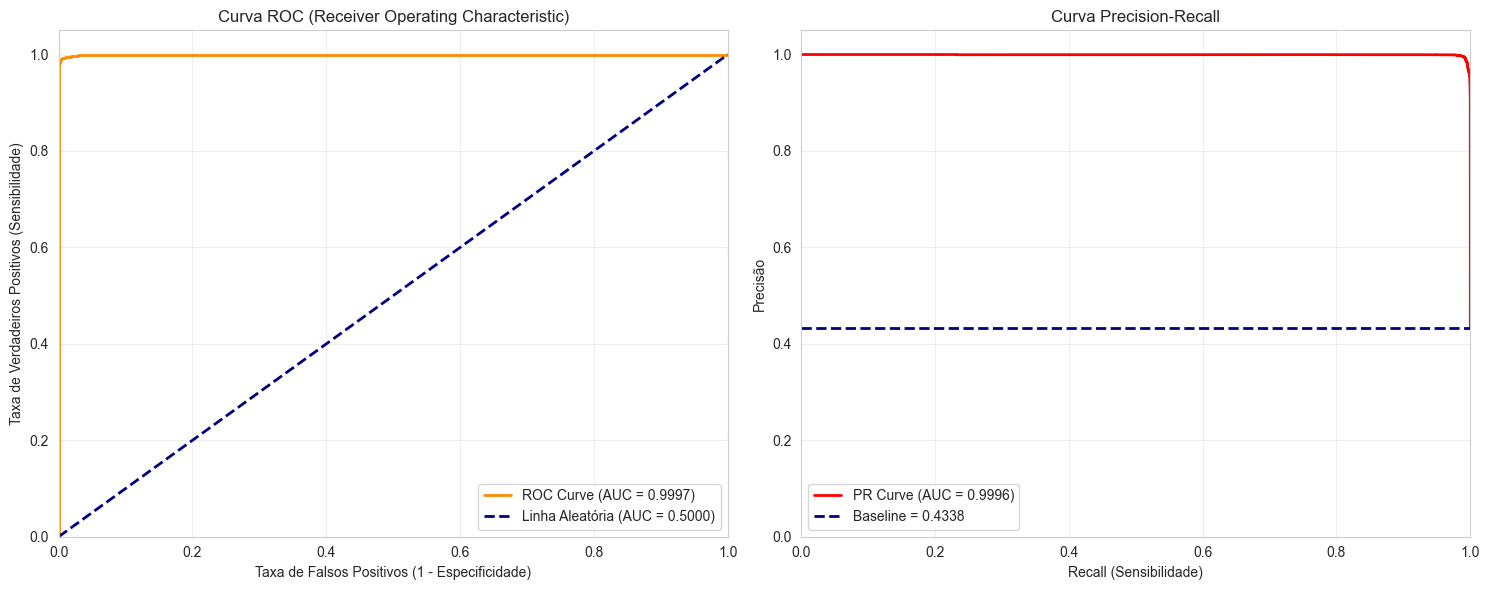


📊 ANÁLISE DAS CURVAS:
   • ROC-AUC: 0.9997
   • PR-AUC:  0.9996
   • Baseline (% classe positiva): 0.4338

🎯 THRESHOLD ÓTIMO:
   • Threshold ótimo (máximo F1): 0.720
   • F1-Score máximo: 0.9929


In [17]:
# Gerar curvas ROC e Precision-Recall
print("📈 Gerando curvas ROC e Precision-Recall...")

if len(np.unique(y_test)) == 2:  # Só para classificação binária
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Curva ROC
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc_curve = auc(fpr, tpr)
    
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC Curve (AUC = {roc_auc_curve:.4f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                label='Linha Aleatória (AUC = 0.5000)')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
    axes[0].set_ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
    axes[0].set_title('Curva ROC (Receiver Operating Characteristic)')
    axes[0].legend(loc="lower right")
    axes[0].grid(True, alpha=0.3)
    
    # Curva Precision-Recall
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    
    axes[1].plot(recall_curve, precision_curve, color='red', lw=2,
                label=f'PR Curve (AUC = {pr_auc:.4f})')
    
    # Linha baseline (proporção da classe positiva)
    baseline = np.sum(y_test) / len(y_test)
    axes[1].axhline(y=baseline, color='navy', linestyle='--', lw=2,
                   label=f'Baseline = {baseline:.4f}')
    
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Recall (Sensibilidade)')
    axes[1].set_ylabel('Precisão')
    axes[1].set_title('Curva Precision-Recall')
    axes[1].legend(loc="lower left")
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 ANÁLISE DAS CURVAS:")
    print(f"   • ROC-AUC: {roc_auc_curve:.4f}")
    print(f"   • PR-AUC:  {pr_auc:.4f}")
    print(f"   • Baseline (% classe positiva): {baseline:.4f}")
    
    # Encontrar threshold ótimo
    # Threshold que maximiza F1-Score
    f1_scores = []
    thresholds_test = np.arange(0.1, 1.0, 0.01)
    
    for thresh in thresholds_test:
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)
        f1_thresh = f1_score(y_test, y_pred_thresh)
        f1_scores.append(f1_thresh)
    
    optimal_threshold = thresholds_test[np.argmax(f1_scores)]
    max_f1 = max(f1_scores)
    
    print(f"\n🎯 THRESHOLD ÓTIMO:")
    print(f"   • Threshold ótimo (máximo F1): {optimal_threshold:.3f}")
    print(f"   • F1-Score máximo: {max_f1:.4f}")
    
else:
    print("⚠️  Curvas ROC e PR disponíveis apenas para classificação binária")
    print("   Para multi-classe, consulte o relatório de classificação abaixo")

## 7. Relatório Detalhado de Classificação

In [18]:
# Relatório de classificação detalhado
print("📋 Gerando relatório detalhado de classificação...")

# Relatório do sklearn
report = classification_report(y_test, y_pred, 
                             target_names=classes_names if classes_mapping else None,
                             output_dict=True)

print(f"\n📊 RELATÓRIO DE CLASSIFICAÇÃO DETALHADO:")
print("="*80)

# Exibir relatório formatado
report_str = classification_report(y_test, y_pred, 
                                 target_names=classes_names if classes_mapping else None)
print(report_str)

# Criar DataFrame do relatório para melhor visualização
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(4)

print(f"\n📊 RESUMO EXECUTIVO:")
print(f"="*50)
print(f"🎯 Modelo: SVM (Support Vector Machine)")
print(f"📊 Dataset: {len(y)} amostras, {X.shape[1]} features")
print(f"🔄 Divisão: {len(y_train)} treino / {len(y_test)} teste")
print(f"⚖️ Normalização: StandardScaler")
print(f"🧠 Kernel: {svm_model.kernel.upper()}")
print(f"\n📈 PERFORMANCE GERAL:")
print(f"   • Acurácia:        {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"   • F1-Score Macro:  {report['macro avg']['f1-score']:.4f}")
print(f"   • F1-Score Pesado: {report['weighted avg']['f1-score']:.4f}")
if len(np.unique(y_test)) == 2:
    print(f"   • ROC-AUC:         {roc_auc:.4f}")

# Análise por classe
print(f"\n🔍 ANÁLISE POR CLASSE:")
for i, classe in enumerate(classes_names):
    if classe in report:
        class_report = report[classe]
        print(f"   Classe '{classe}':")
        print(f"     • Precisão: {class_report['precision']:.4f}")
        print(f"     • Recall:   {class_report['recall']:.4f}")
        print(f"     • F1-Score: {class_report['f1-score']:.4f}")
        print(f"     • Suporte:  {int(class_report['support'])} amostras")

print(f"\n" + "="*80)

📋 Gerando relatório detalhado de classificação...

📊 RELATÓRIO DE CLASSIFICAÇÃO DETALHADO:
              precision    recall  f1-score   support

      interf       1.00      0.99      0.99     13698
      normal       0.99      0.99      0.99     10496

    accuracy                           0.99     24194
   macro avg       0.99      0.99      0.99     24194
weighted avg       0.99      0.99      0.99     24194


📊 RESUMO EXECUTIVO:
🎯 Modelo: SVM (Support Vector Machine)
📊 Dataset: 80648 amostras, 122 features
🔄 Divisão: 32259 treino / 24194 teste
⚖️ Normalização: StandardScaler
🧠 Kernel: RBF

📈 PERFORMANCE GERAL:
   • Acurácia:        0.9916 (99.2%)
   • F1-Score Macro:  0.9914
   • F1-Score Pesado: 0.9916
   • ROC-AUC:         0.9997

🔍 ANÁLISE POR CLASSE:
   Classe 'interf':
     • Precisão: 0.9953
     • Recall:   0.9898
     • F1-Score: 0.9925
     • Suporte:  13698 amostras
   Classe 'normal':
     • Precisão: 0.9868
     • Recall:   0.9939
     • F1-Score: 0.9903
     • Suport

## 8. Validação Cruzada

🔄 Realizando validação cruzada...
📊 Executando validação cruzada (5-folds)...

📊 RESULTADOS DA VALIDAÇÃO CRUZADA (5-folds):
Acurácia    : 0.9955 ± 0.0004 | Range: [0.9950, 0.9961]
Precisão    : 0.9955 ± 0.0004 | Range: [0.9950, 0.9961]
Recall      : 0.9955 ± 0.0004 | Range: [0.9950, 0.9961]
F1-Score    : 0.9955 ± 0.0004 | Range: [0.9950, 0.9961]
ROC-AUC     : 0.9998 ± 0.0001 | Range: [0.9997, 0.9999]

🔍 ANÁLISE DA ESTABILIDADE:
   • Acurácia: Muito Estável (CV: 0.0%)
   • Precisão: Muito Estável (CV: 0.0%)
   • Recall: Muito Estável (CV: 0.0%)
   • F1-Score: Muito Estável (CV: 0.0%)
   • ROC-AUC: Muito Estável (CV: 0.0%)


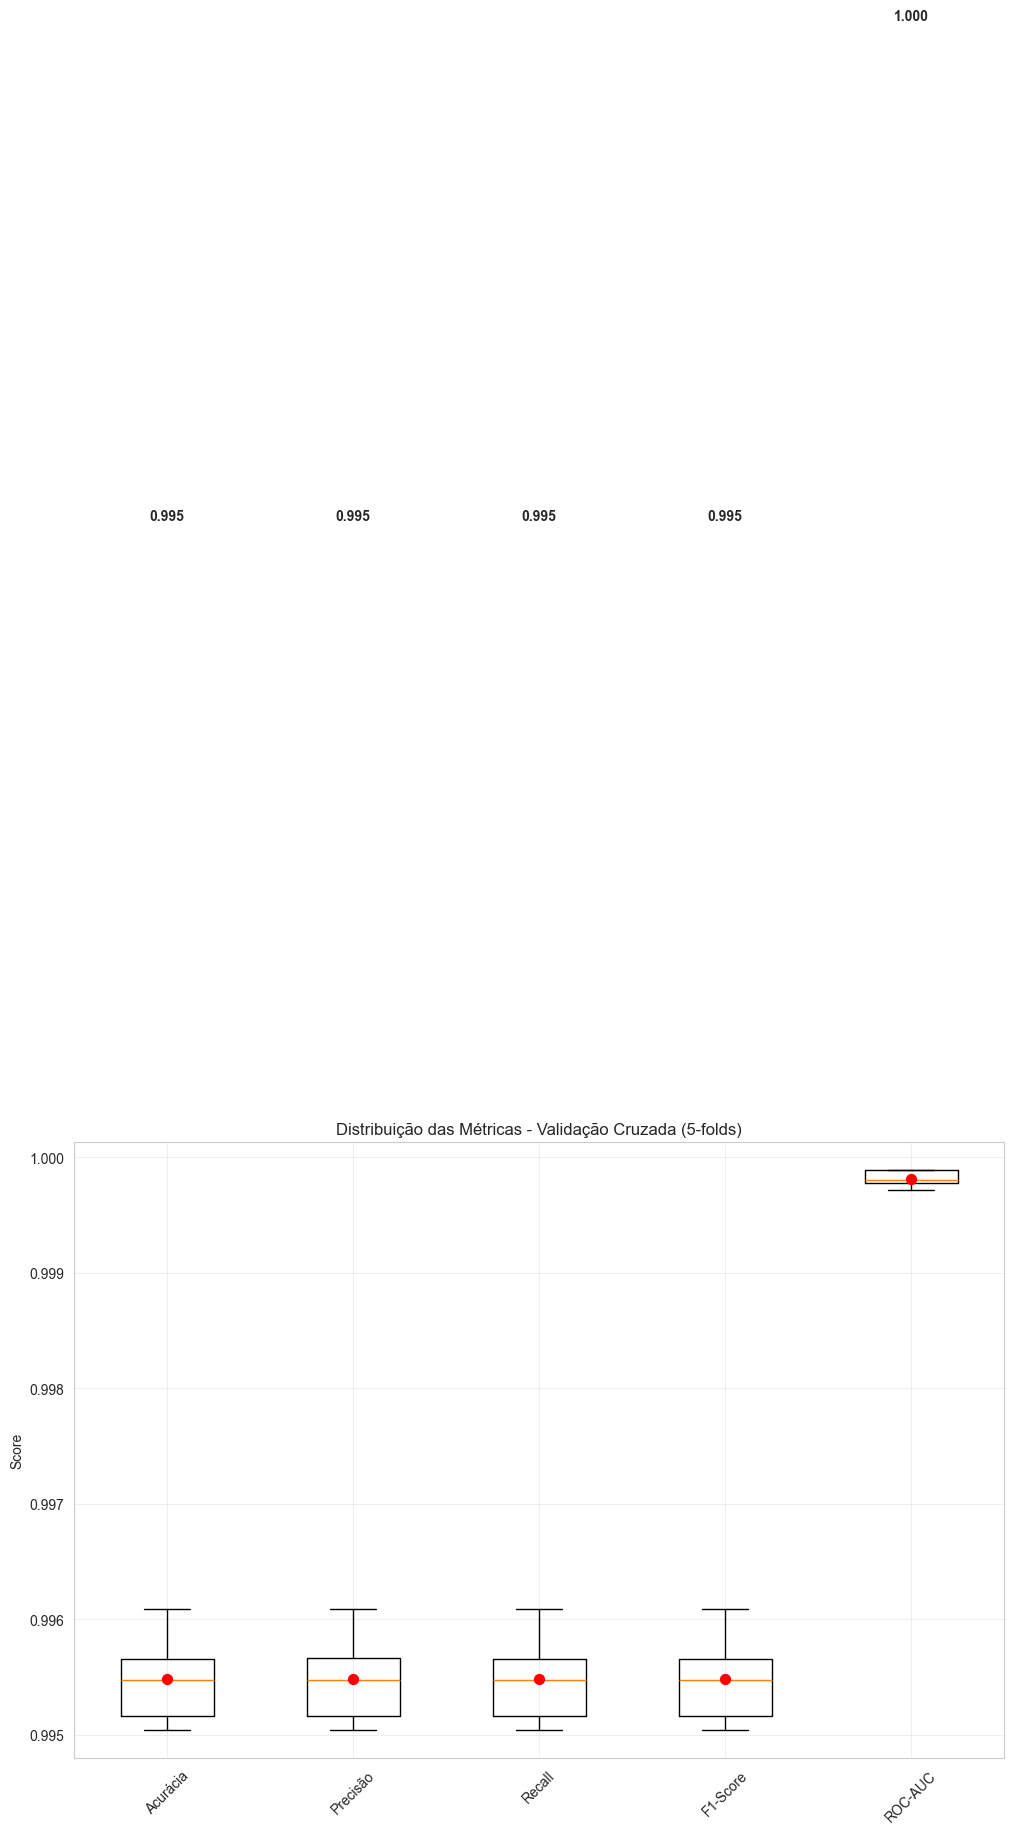


✅ Validação cruzada concluída!


In [19]:
# Validação cruzada para avaliar a estabilidade do modelo
print("🔄 Realizando validação cruzada...")

# Configurar validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Treinar dados completos com Yeo-Johnson
X_full_scaled = yeo_johnson_transformer.fit_transform(X)

print(f"📊 Executando validação cruzada (5-folds)...")

# Calcular métricas com validação cruzada
cv_accuracy = cross_val_score(svm_model, X_full_scaled, y_encoded, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(svm_model, X_full_scaled, y_encoded, cv=cv, scoring='precision_weighted')
cv_recall = cross_val_score(svm_model, X_full_scaled, y_encoded, cv=cv, scoring='recall_weighted')
cv_f1 = cross_val_score(svm_model, X_full_scaled, y_encoded, cv=cv, scoring='f1_weighted')

# ROC-AUC para validação cruzada
if len(np.unique(y_encoded)) == 2:
    cv_roc_auc = cross_val_score(svm_model, X_full_scaled, y_encoded, cv=cv, scoring='roc_auc')
else:
    cv_roc_auc = cross_val_score(svm_model, X_full_scaled, y_encoded, cv=cv, scoring='roc_auc_ovr_weighted')

print(f"\n📊 RESULTADOS DA VALIDAÇÃO CRUZADA (5-folds):")
print(f"="*60)

metrics_cv = {
    'Acurácia': cv_accuracy,
    'Precisão': cv_precision,
    'Recall': cv_recall,
    'F1-Score': cv_f1,
    'ROC-AUC': cv_roc_auc
}

for metric_name, scores in metrics_cv.items():
    mean_score = scores.mean()
    std_score = scores.std()
    print(f"{metric_name:12s}: {mean_score:.4f} ± {std_score:.4f} | "
          f"Range: [{scores.min():.4f}, {scores.max():.4f}]")

print(f"\n🔍 ANÁLISE DA ESTABILIDADE:")

# Analisar estabilidade baseada no desvio padrão
for metric_name, scores in metrics_cv.items():
    cv_coefficient = (scores.std() / scores.mean()) * 100  # Coeficiente de variação
    
    if cv_coefficient < 5:
        stability = "Muito Estável"
    elif cv_coefficient < 10:
        stability = "Estável"
    elif cv_coefficient < 20:
        stability = "Moderadamente Estável"
    else:
        stability = "Instável"
    
    print(f"   • {metric_name}: {stability} (CV: {cv_coefficient:.1f}%)")

# Visualização dos resultados da validação cruzada
plt.figure(figsize=(12, 8))

metrics_names = list(metrics_cv.keys())
metrics_values = [list(scores) for scores in metrics_cv.values()]

# Box plot das métricas
plt.boxplot(metrics_values, labels=metrics_names)
plt.title('Distribuição das Métricas - Validação Cruzada (5-folds)')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Adicionar médias como pontos
for i, scores in enumerate(metrics_values, 1):
    plt.scatter(i, np.mean(scores), color='red', s=50, zorder=5)
    plt.text(i, np.mean(scores) + 0.01, f'{np.mean(scores):.3f}', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Validação cruzada concluída!")

## 9. Salvamento dos Resultados

In [20]:
# Salvar todos os resultados em arquivos
print("💾 Salvando resultados...")

# 1. Salvar métricas principais
metricas_principais = {
    'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Valor': [accuracy, precision, recall, f1, roc_auc],
    'Percentual': [f"{accuracy*100:.2f}%", f"{precision*100:.2f}%", 
                   f"{recall*100:.2f}%", f"{f1*100:.2f}%", f"{roc_auc*100:.2f}%"]
}

df_metricas = pd.DataFrame(metricas_principais)
df_metricas.to_csv('metricas_avaliacao_svm.csv', index=False)
print(f"✅ Métricas principais salvas: metricas_avaliacao_svm.csv")

# 2. Salvar matriz de confusão
df_confusion = pd.DataFrame(cm, index=classes_names, columns=classes_names)
df_confusion.to_csv('matriz_confusao_svm.csv')
print(f"✅ Matriz de confusão salva: matriz_confusao_svm.csv")

# 3. Salvar relatório de classificação
df_report.to_csv('relatorio_classificacao_svm.csv')
print(f"✅ Relatório de classificação salvo: relatorio_classificacao_svm.csv")

# 4. Salvar resultados da validação cruzada
cv_results = {
    'Fold': list(range(1, 6)) * 5,
    'Métrica': ['Acurácia']*5 + ['Precisão']*5 + ['Recall']*5 + ['F1-Score']*5 + ['ROC-AUC']*5,
    'Score': np.concatenate([cv_accuracy, cv_precision, cv_recall, cv_f1, cv_roc_auc])
}

df_cv_results = pd.DataFrame(cv_results)
df_cv_results.to_csv('validacao_cruzada_svm.csv', index=False)
print(f"✅ Validação cruzada salva: validacao_cruzada_svm.csv")

# 5. Criar relatório resumo
with open('resumo_avaliacao_svm.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 70 + "\n")
    f.write("RESUMO DA AVALIAÇÃO - MODELO SVM\n")
    f.write(f"Dataset: svm.csv\n")
    f.write(f"Gerado em: {pd.Timestamp.now()}\n")
    f.write("=" * 70 + "\n\n")
    
    f.write("CONFIGURAÇÃO DO MODELO:\n")
    f.write(f"• Algoritmo: SVM (Support Vector Machine)\n")
    f.write(f"• Kernel: {svm_model.kernel}\n")
    f.write(f"• Parâmetro C: {svm_model.C}\n")
    f.write(f"• Gamma: {svm_model.gamma}\n")
    f.write(f"• Normalização: Yeo-Johnson + StandardScaler\n")
    f.write(f"• Features: {X.shape[1]}\n")
    f.write(f"• Amostras totais: {len(y):,}\n")
    f.write(f"• Divisão treino/teste: {len(y_train):,} / {len(y_test):,}\n\n")
    
    f.write("MÉTRICAS DE AVALIAÇÃO (Teste):\n")
    f.write(f"• Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)\n")
    f.write(f"• Precisão: {precision:.4f} ({precision*100:.2f}%)\n")
    f.write(f"• Recall: {recall:.4f} ({recall*100:.2f}%)\n")
    f.write(f"• F1-Score: {f1:.4f} ({f1*100:.2f}%)\n")
    f.write(f"• ROC-AUC: {roc_auc:.4f} ({roc_auc*100:.2f}%)\n\n")
    
    f.write("VALIDAÇÃO CRUZADA (5-folds):\n")
    for metric_name, scores in metrics_cv.items():
        f.write(f"• {metric_name}: {scores.mean():.4f} ± {scores.std():.4f}\n")
    
    f.write(f"\nMATRIZ DE CONFUSÃO:\n")
    f.write(f"{cm}\n\n")
    
    f.write("ARQUIVOS GERADOS:\n")
    f.write("• metricas_avaliacao_svm.csv - Métricas principais\n")
    f.write("• matriz_confusao_svm.csv - Matriz de confusão\n")
    f.write("• relatorio_classificacao_svm.csv - Relatório detalhado\n")
    f.write("• validacao_cruzada_svm.csv - Resultados CV\n")
    f.write("• resumo_avaliacao_svm.txt - Este arquivo\n")

print(f"✅ Resumo executivo salvo: resumo_avaliacao_svm.txt")

print(f"\n🎉 ANÁLISE CONCLUÍDA COM SUCESSO!")
print(f"📁 Arquivos gerados: 5 arquivos")
print(f"📊 Todas as métricas calculadas e salvas")
print(f"🔲 Matriz de confusão gerada e visualizada")
print(f"📈 Curvas ROC e PR criadas (se aplicável)")
print(f"🔄 Validação cruzada realizada")

💾 Salvando resultados...
✅ Métricas principais salvas: metricas_avaliacao_svm.csv
✅ Matriz de confusão salva: matriz_confusao_svm.csv
✅ Relatório de classificação salvo: relatorio_classificacao_svm.csv
✅ Validação cruzada salva: validacao_cruzada_svm.csv
✅ Resumo executivo salvo: resumo_avaliacao_svm.txt

🎉 ANÁLISE CONCLUÍDA COM SUCESSO!
📁 Arquivos gerados: 5 arquivos
📊 Todas as métricas calculadas e salvas
🔲 Matriz de confusão gerada e visualizada
📈 Curvas ROC e PR criadas (se aplicável)
🔄 Validação cruzada realizada


---

## 🎯 Resumo Final

Este notebook implementou uma **análise completa de métricas de avaliação** para o modelo SVM:

### ✅ Métricas Calculadas:
1. **📊 Acurácia** - Percentual de predições corretas
2. **🎯 Precisão** - Proporção de positivos preditos que são realmente positivos
3. **📈 Recall** - Proporção de positivos reais que foram corretamente identificados
4. **⚖️ F1-Score** - Média harmônica entre precisão e recall
5. **📈 ROC-AUC** - Área sob a curva ROC
6. **🔲 Matriz de Confusão** - Visualização detalhada dos acertos e erros

### 📊 Visualizações Criadas:
- Matriz de confusão (absoluta e normalizada)
- Curvas ROC e Precision-Recall
- Box plots da validação cruzada

### 💾 Arquivos Gerados:
- `metricas_avaliacao_svm.csv` - Métricas principais
- `matriz_confusao_svm.csv` - Matriz de confusão
- `relatorio_classificacao_svm.csv` - Relatório detalhado por classe
- `validacao_cruzada_svm.csv` - Resultados da validação cruzada
- `resumo_avaliacao_svm.txt` - Resumo executivo completo

### 🔍 Análises Incluídas:
- Avaliação de performance no conjunto de teste
- Validação cruzada para estabilidade do modelo
- Análise por classe individual
- Interpretação das métricas
- Threshold ótimo para classificação

**O notebook está pronto para avaliar completamente o desempenho do seu modelo SVM!**